**Tên dự án:** AG News Classification NLP <br>
**Mục tiêu:** Tạo mô hình ML, DL để phân tích AG News.. <br>
**Phương pháp:**
*   Các thư viện và tập dữ liệu cần thiết cho dự án này.
*   Tiền xử lý tập dữ liệu:
    *   chữ thường của văn bản (lower text)
    *   loại bỏ dấu chấm câu (punctuations)
    *   loại bỏ từ khóa (stopwords)
    *   loại bỏ các khoảng trống thừa
*   Tokenization
*   Phân tích dữ liệu thăm dò và trực quan hóa các khía cạnh khác nhau của tập dữ liệu.
*   Vẽ đồ thị các thuộc tính khác nhau của tập dữ liệu.
*   Áp dụng các thuật toán học máy

#1. Tập dữ liệu

Tập dữ liệu cho dự án này được lấy từ trang web tập dữ liệu Kaggle. Đây là liên kết cho tập dữ liệu:https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset

# 2. Tiền xử lý dữ liệu

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)
folder = '/content/gdrive/My Drive/Colab Notebooks'

Mounted at /content/gdrive


# Import thư viện và data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')
stopwords = set(STOP_WORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.remove("not")
stopwords.remove("no")
stopwords.add(" ")

from nltk.stem import WordNetLemmatizer    # lemmatize
from wordcloud import WordCloud, STOPWORDS
import string



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
train_df = pd.read_csv('/content/gdrive/MyDrive/NLP cuoi ki/train.csv', delimiter=',', header=None, names=['index', 'title', 'description'])
test_df = pd.read_csv('/content/gdrive/MyDrive/NLP cuoi ki/test.csv', delimiter=',', header=None, names=['index', 'title', 'description'])
train_df.head()

,index,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [4]:
print(train_df.shape)
print(test_df.shape)

(120000, 3)
(7600, 3)


In [5]:
df = train_df.copy()

In [6]:
df.head()

,index,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [7]:
# Thêm cột label cho data
labels = {1:'World',2:'Sports',3:'Business',4:'Science'}
df['labels'] = df['index'].map(labels)

In [8]:
df.head()

,index,title,description,labels
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Business
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Business
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Business
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",Business


In [9]:
# Gộp 2 cột nội dung và tiêu đề lại
df['content'] = df['title'] + ' ' + df['description']
df.drop(columns=['title', 'description'],inplace=True)

In [10]:
df.head()

,index,labels,content
0,3,Business,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,Business,"Oil prices soar to all-time record, posing new..."


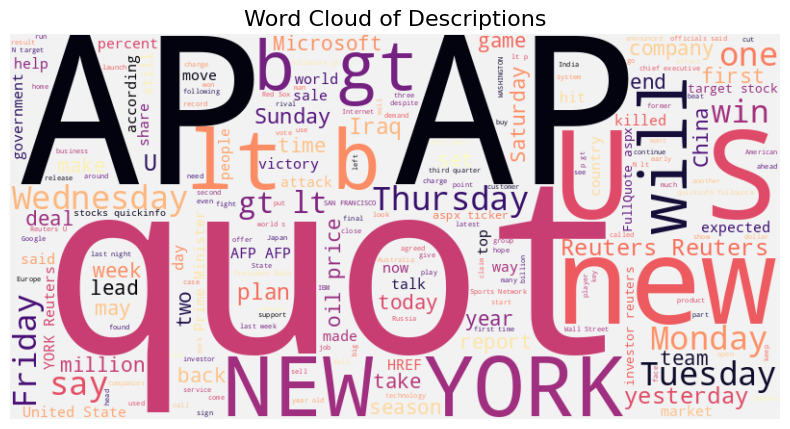

In [11]:
# Hiển thị wordcloud cho các từ xuất hiện nhiều nhất
def cloud(word, title, colormap='viridis', background_color='white'):
    wordcloud = WordCloud(width=800, height=400, background_color=background_color, colormap=colormap, random_state=42).generate(word)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

all_descriptions = ' '.join(df['content'].values)
cloud(all_descriptions, "Word Cloud of Descriptions", colormap='magma', background_color='#f2f2f2')


# Text Preprocessing

## 2.1. Chuyển đổi các từ viết tắt (contractions) thành dạng đầy đủ


In [12]:
import re
import pandas as pd

def unique_characters(df, column_name):
    all_characters = set()

    # Tập hợp tất cả các ký tự không phải tiếng Anh từ toàn bộ cột
    for value in df[column_name]:
        non_characters = set(re.findall(r"[^\w\s]", str(value)))
        all_characters.update(non_characters)

    # In các ký tự không phải tiếng Anh
    print("Non-English characters:", all_characters)

unique_characters(df, 'content')


Non-English characters: {'=', ',', '-', ')', '.', "'", '"', ';', '!', '#', ':', '$', '?', '/', '&', '(', '*', '\\'}


In [13]:
def preprocess_text(text):
    text = str(text).lower()
    text = text.replace('$', 'dollar')\
               .replace(',000,000', 'm').replace('000', 'k')\
               .replace("won't", 'will not').replace("can't", 'can not')\
               .replace("shouldn't", 'should not').replace("what's", '"what is"')\
               .replace("that's", 'that is').replace("he's", 'he is')\
               .replace("she's", 'she is').replace("it's", 'it is')\
               .replace("'ve", 'have').replace("'re", 'are')\
               .replace("'ll", 'will').replace("i'm", 'i am')\
               .replace("n't", " not")
    text = re.sub(r'([0-9]+)000000', r'\1m', text)
    text = re.sub(r'([0-9]+)000', r'\1k', text)

    return text

def extract_features(df):
    df['content'] = df['content'].fillna("").apply(preprocess_text)
    return df
df = extract_features(df)

## 2.2. Loại bỏ URLs

In [14]:
# Hiển thị số lượng dòng có chứa URL
from urllib.parse import urlparse
rows_urls = df['content'].apply(lambda x: bool(urlparse(x).scheme)).sum()
print("Số lượng dòng có chứa URL:", rows_urls)

Số lượng dòng có chứa URL: 4494


In [15]:
# loại bỏ urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

df['content'] = df['content'].apply(remove_urls)

## 2.3. Loại bỏ HTML

In [16]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

df['content'] = df['content'].apply(remove_html)

## 2.4. Tokenize

In [17]:
def word_tokenize(txt):
    tokens = re.findall("[\w']+", txt)
    return tokens
df['content'] = df['content'].apply(word_tokenize)

## 2.5. Loại bỏ stopwords

In [18]:
def filter_out_stopwords(tokens):
    stop_words = stopwords
    filtered_tokens = []
    for token in tokens:
        if token not in stop_words:
            filtered_tokens.append(token)
    return filtered_tokens

df['content'] = df['content'].apply(filter_out_stopwords)


## 2.6. Loại bỏ từ không có ý nghĩa xuất hiện nhiều

In [19]:
def remove_meaningless_tokens(tokens):
    stop_tokens = ['href', 'lt', 'gt', 'ii', 'iii', 'ie', 'quot', 'com', 'u']
    new_tokens = []
    for token in tokens:
        if token not in stop_tokens:
            new_tokens.append(token)
    return new_tokens

df['content'] = df['content'].apply(remove_meaningless_tokens)


## 2.8. Loại bỏ các ký hiệu dấu chấm câu

In [20]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [21]:
import string

def remove_punctuations(tokens):
    new_tokens = []
    for token in tokens:
        for punctuation in string.punctuation:
            token = token.replace(punctuation, '')
        new_tokens.append(token)
    return new_tokens

df['content'] = df['content'].apply(remove_punctuations)


## 2.9. Loại bỏ số

In [22]:
def remove_digits(tokens):
    no_digits_tokens = []
    new_tokens = []

    for token in tokens:
        for digit in string.digits:
            token = token.replace(digit, '')
        no_digits_tokens.append(token)

    for token in no_digits_tokens:
        if token != '':
            new_tokens.append(token)

    return new_tokens
df['content'] = df['content'].apply(remove_digits)

## 2.10. Chuyển đổi các từ về dạng gốc (Lemmatization)

In [23]:
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    new_tokens = []
    for token in tokens:
        token = lemmatizer.lemmatize(token)
        new_tokens.append(token)
    return new_tokens

df['content'] = df['content'].apply(lemmatize_tokens)


# 3. Phân tích dữ liệu (EDA) và Trực quan hóa


# 3.1. Biểu đồ phân phối mục tiêu

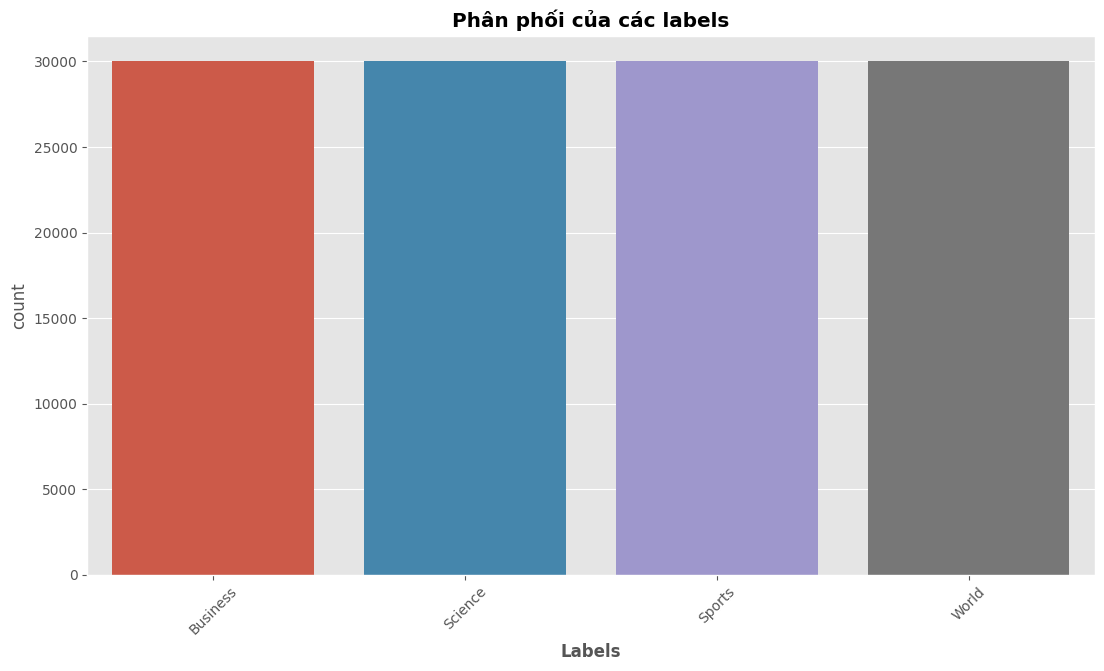

In [24]:

plt.figure(figsize=(13, 7))
plt.style.use('ggplot')
sns.countplot(x = 'labels', data = df)
plt.title('Phân phối của các labels', fontweight='bold')
plt.xlabel('Labels', fontweight='bold')
plt.xticks(rotation=45);

## 3.2. WorldCloud trước và sau khi loại bỏ stopwords

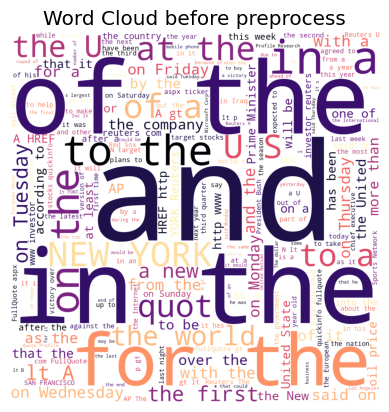

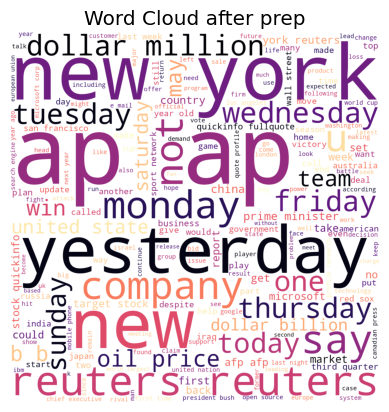

In [25]:
import plotly.express as px
from collections import Counter

df['content_str'] = df['content'].apply(lambda x: ' '.join(x))
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=1200, height=1200, background_color='white',colormap='magma', stopwords=set()).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

raw = ' '.join(train_df['description'].values)
all_descriptions = ' '.join(df['content_str'].values)

plot_wordcloud(raw, "Word Cloud before preprocess")
plot_wordcloud(all_descriptions, "Word Cloud after prep")


## 3.3. Biểu đồ tấn suất 200 từ xuất hiện nhiều nhất

In [26]:
word_counter = Counter(' '.join(df['content_str']).split())

# top 200 words
top_words = dict(word_counter.most_common(200))
df_top_words = pd.DataFrame(list(top_words.items()), columns=['Word', 'Frequency'])

# treemap
fig = px.treemap(df_top_words, path=['Word'], values='Frequency', width=1200, height=700)
fig.update_layout(title_text='Top 200 từ xuất hiện nhiều trong Dataset', title_x=0.5, title_font=dict(size=20))
fig.update_traces(textinfo="label+value")
fig.show()

## 3.4. Biểu đồ N-grams

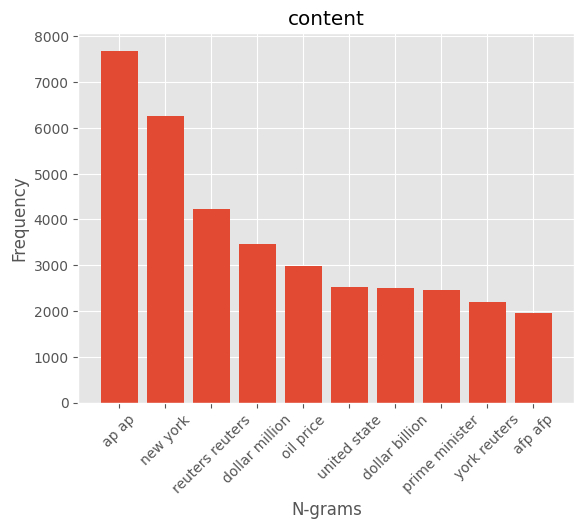

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

# Phân tích N-gram
def plot_top_ngrams(corpus, n, g, text_type):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(tokens, sum_words[0, idx]) for tokens, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

    plt.bar([x[0] for x in words_freq], [x[1] for x in words_freq])
    plt.xticks(rotation=45)
    plt.xlabel("N-grams")
    plt.ylabel("Frequency")
    plt.title(f"{text_type}")
    plt.show()

plot_top_ngrams(df['content_str'], 10, 2, "content")

# 4. Xây dựng Model

## 4.1 Chia tập train và test

In [28]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df['content_str'], df['labels'], test_size=0.2, random_state = 42)

In [29]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((96000,), (24000,), (96000,), (24000,))

# 4.2. Naive Bayes

In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

nb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

nb.fit(x_train, y_train)
y_pred_nb = nb.predict(x_test)

print('Accuracy:', accuracy_score(y_test, y_pred_nb))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_nb))


Accuracy: 0.9047916666666667

Classification Report:
              precision    recall  f1-score   support

    Business       0.86      0.87      0.87      5911
     Science       0.89      0.87      0.88      6075
      Sports       0.95      0.98      0.96      6058
       World       0.92      0.89      0.90      5956

    accuracy                           0.90     24000
   macro avg       0.90      0.90      0.90     24000
weighted avg       0.90      0.90      0.90     24000



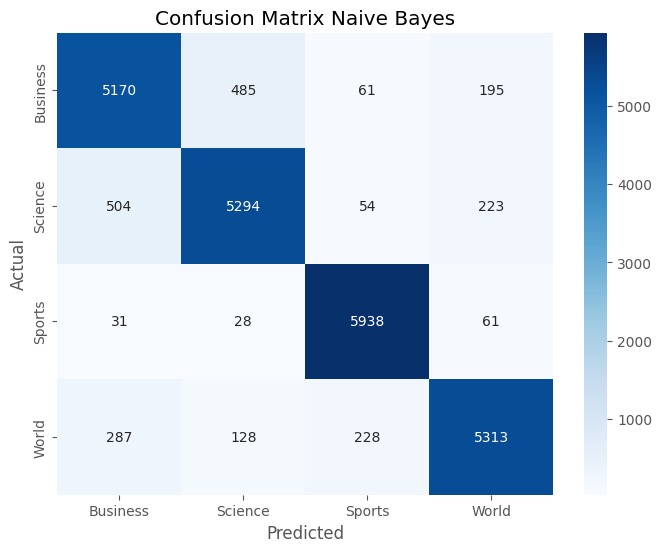

In [31]:
# Ma trận nhầm lẫn Nb
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title('Confusion Matrix Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 4.3. Maxent (SGD)

In [33]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
sgd = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='log_loss', penalty='l2', alpha=1e-3, random_state=42, max_iter=100, tol=None))
])

sgd.fit(x_train, y_train)
y_pred_sgd = sgd.predict(x_test)

print('accuracy %s : ' % accuracy_score(y_pred_sgd, y_test))
print(classification_report(y_test, y_pred_sgd))

accuracy 0.87425 : 
              precision    recall  f1-score   support

    Business       0.86      0.81      0.83      5911
     Science       0.87      0.83      0.85      6075
      Sports       0.88      0.98      0.92      6058
       World       0.89      0.88      0.89      5956

    accuracy                           0.87     24000
   macro avg       0.87      0.87      0.87     24000
weighted avg       0.87      0.87      0.87     24000



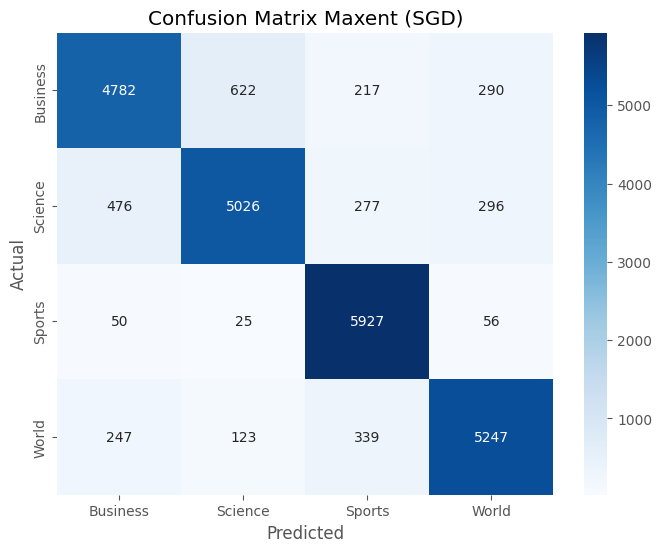

In [34]:
# Ma trận nhầm lẫn sgd
cm_sgd = confusion_matrix(y_test, y_pred_sgd)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_sgd, annot=True, fmt='d', cmap='Blues', xticklabels=sgd.classes_, yticklabels=sgd.classes_)
plt.title('Confusion Matrix Maxent (SGD)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 4.4. CNN

##  Chuyển đổi chuỗi văn bản thành chuỗi số nguyên


In [35]:
from keras.preprocessing.text import Tokenizer
max_words = 10000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(df['content_str'])
sequence = tok.texts_to_sequences(df['content_str'])

In [36]:
df.head()

,index,labels,content,content_str
0,3,Business,"[wall, st, bear, claw, back, black, reuters, r...",wall st bear claw back black reuters reuters s...
1,3,Business,"[carlyle, look, toward, commercial, aerospace,...",carlyle look toward commercial aerospace reute...
2,3,Business,"[oil, economy, cloud, stock, outlook, reuters,...",oil economy cloud stock outlook reuters reuter...
3,3,Business,"[iraq, halt, oil, export, main, southern, pipe...",iraq halt oil export main southern pipeline re...
4,3,Business,"[oil, price, soar, time, record, posing, new, ...",oil price soar time record posing new menace u...


In [37]:
# Tạo cột số từ trong bài viết theo từng nhóm mới
df['word_seq'] = sequence
df['num_words'] = df['word_seq'].str.len()

In [38]:
df.head()

,index,labels,content,content_str,word_seq,num_words
0,3,Business,"[wall, st, bear, claw, back, black, reuters, r...",wall st bear claw back black reuters reuters s...,"[364, 312, 1175, 54, 695, 2, 2, 649, 4231, 364...",16
1,3,Business,"[carlyle, look, toward, commercial, aerospace,...",carlyle look toward commercial aerospace reute...,"[320, 779, 1085, 3656, 2, 2, 811, 593, 171, 41...",23
2,3,Business,"[oil, economy, cloud, stock, outlook, reuters,...",oil economy cloud stock outlook reuters reuter...,"[16, 276, 2730, 21, 633, 2, 2, 2145, 403, 25, ...",23
3,3,Business,"[iraq, halt, oil, export, main, southern, pipe...",iraq halt oil export main southern pipeline re...,"[29, 1500, 16, 1137, 815, 476, 2114, 2, 2, 563...",28
4,3,Business,"[oil, price, soar, time, record, posing, new, ...",oil price soar time record posing new menace u...,"[16, 25, 2360, 26, 80, 6395, 1, 9041, 5, 276, ...",28


In [39]:
## Xử lý text để độ dài các chuỗi là như nhau
from keras.preprocessing.sequence import pad_sequences
max_len = 60 # độ dài max là 60
data = pad_sequences(df['word_seq'], maxlen=max_len)

In [40]:
data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        364,  312, 1175,   54,  695,    2,    2,  649, 4231,  364,  253,
       8725, 2308, 4992, 3515,  674], dtype=int32)

In [41]:
## sử dụng LabelEncoder để mã hóa các cột labels
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

encoder = LabelEncoder()
encoder.fit(df['labels'])
labels = encoder.transform(df['labels'])
n_classes = max(labels) + 1
labels = to_categorical(labels, n_classes)

In [42]:
labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [43]:
labels.shape

(120000, 4)

## Chia dữ liệu thành các tập train, test, val cho CNN model

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((96000, 60), (24000, 60), (96000, 4), (24000, 4))

In [45]:
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=20)
x_train.shape, x_val.shape

((76800, 60), (19200, 60))

In [46]:
X_train

array([[   0,    0,    0, ..., 2111,  908, 2475],
       [   0,    0,    0, ...,  173,  376,  194],
       [   0,    0,    0, ...,  629,   55,   19],
       ...,
       [   0,    0,    0, ..., 5095,  646,  386],
       [   0,    0,    0, ...,  303,   67, 2587],
       [   0,    0,    0, ..., 1108,  975, 1361]], dtype=int32)

In [47]:
# Xây dựng mô hình CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import tensorflow as tf

model = Sequential()
model.add(Embedding(max_words, 64, input_length=max_len))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))  # Thêm lớp Dropout
model.add(Flatten())
model.add(Dense(64, activation='relu'))  # Giảm số đơn vị trong lớp Dense
model.add(Dropout(0.5))  # Thêm lớp Dropout
model.add(Dense(n_classes, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 64)            640000    
                                                                 
 conv1d (Conv1D)             (None, 58, 64)            12352     
                                                                 
 max_pooling1d (MaxPooling1  (None, 29, 64)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 29, 64)            0         
                                                                 
 flatten (Flatten)           (None, 1856)              0         
                                                                 
 dense (Dense)               (None, 64)                118848    
                                                        

In [48]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
                x_train,
                y_train,
                epochs=5,
                batch_size=128,
                validation_data=(x_val, y_val)
            )

Epoch 1/5
600/600 [==============================] - 22s 35ms/step - loss: 0.4835 - accuracy: 0.8167 - val_loss: 0.2617 - val_accuracy: 0.9124
Epoch 2/5
600/600 [==============================] - 22s 37ms/step - loss: 0.2376 - accuracy: 0.9234 - val_loss: 0.2566 - val_accuracy: 0.9140
Epoch 3/5
600/600 [==============================] - 21s 35ms/step - loss: 0.1992 - accuracy: 0.9339 - val_loss: 0.2676 - val_accuracy: 0.9131
Epoch 4/5
600/600 [==============================] - 21s 35ms/step - loss: 0.1699 - accuracy: 0.9422 - val_loss: 0.2878 - val_accuracy: 0.9110
Epoch 5/5
600/600 [==============================] - 24s 40ms/step - loss: 0.1420 - accuracy: 0.9508 - val_loss: 0.3121 - val_accuracy: 0.9091


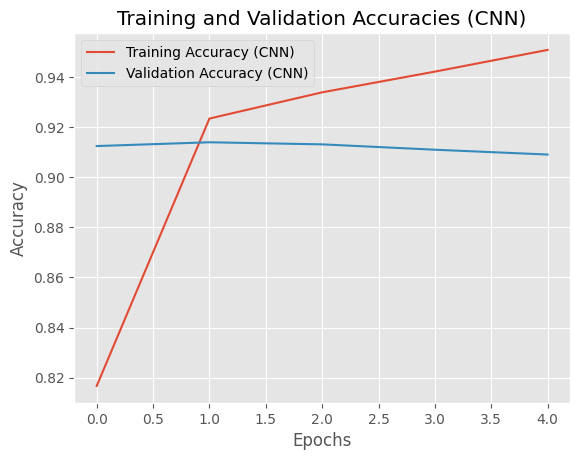

In [49]:
# Biểu đồ accuracy của train và val
plt.plot(history.history['accuracy'], label='Training Accuracy (CNN)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracies (CNN)')
plt.show()

750/750 [==============================] - 3s 4ms/step - loss: 0.3279 - accuracy: 0.9050
CNN Accuracy: 0.9050416946411133


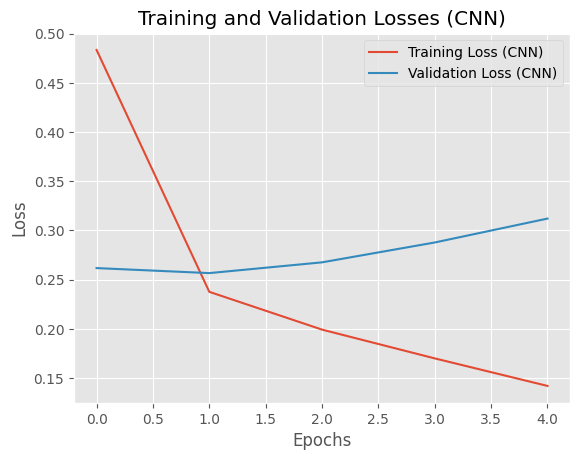

In [50]:
cnn_test_loss, cnn_test_acc = model.evaluate(X_test, y_test)
print("CNN Accuracy:", cnn_test_acc)
# Biểu đồ loss của train và val (CNN)
plt.plot(history.history['loss'], label='Training Loss (CNN)')
plt.plot(history.history['val_loss'], label='Validation Loss (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses (CNN)')
plt.show()


750/750 [==============================] - 4s 5ms/step


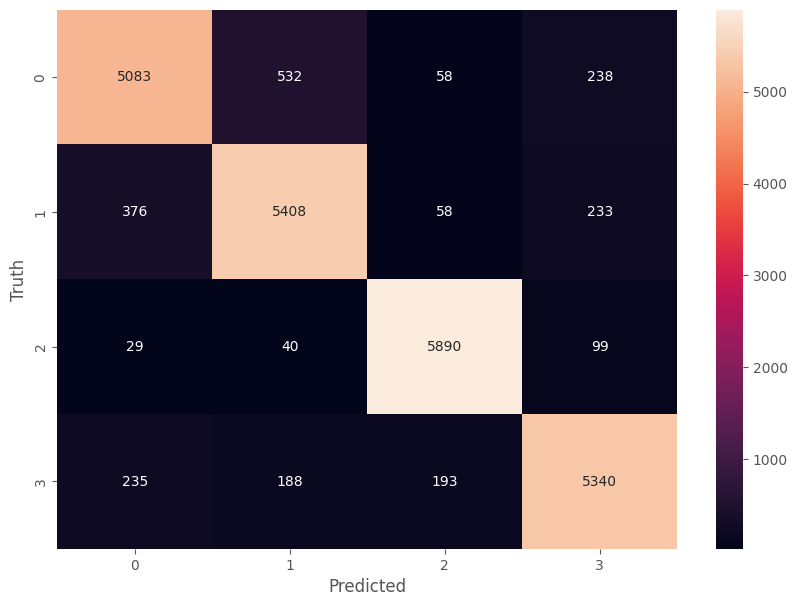

In [51]:
# Dự đoán cho tập kiểm tra bằng mô hình CNN
y_pred_CNN = model.predict(X_test)
y_pred_CNN = np.argmax(y_pred_CNN, axis=1)

y_test_argmax = np.argmax(y_test, axis=1)

# Confusion matrix CNN
cm_CNN = tf.math.confusion_matrix(labels=y_test_argmax, predictions=y_pred_CNN)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_CNN, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [52]:
# model.save("AG_News_text_classification_model.h5")

# Dự đoán

## CNN

In [53]:
from flask import Flask, render_template, request
from tensorflow.keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')
stopwords = set(STOP_WORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.remove("not")
stopwords.remove("no")
stopwords.add(" ")

In [54]:
max_words = 10000
tok = Tokenizer(num_words=max_words)

max_len = 60

# Function for text processing
def process_text(text):
    text = str(text).lower()

    # Tokenize
    tokens = re.findall("[\w']+", text)

    # Filter out stopwords using NLTK stopwords
    stop_words = stopwords
    tokens = [token for token in tokens if token.lower() not in stop_words]

    # Remove punctuations
    tokens = [''.join(char for char in token if char not in string.punctuation) for token in tokens]

    # Remove digits
    tokens = [''.join(char for char in token if not char.isdigit()) for token in tokens]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

# Function for prediction
def predict(text):
    # Text processing
    processed_text = process_text(text)
    processed_text = ' '.join(processed_text)
    # Convert to sequence using the tokenizer
    tok.fit_on_texts([processed_text])
    processed_sequence = tok.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(processed_sequence, maxlen=max_len)

    # Prediction
    prediction = model.predict(padded_sequence)

    # Handling prediction result
    predicted_class = np.argmax(prediction)
    max_probability = np.max(prediction)


    # Map the numerical label to its corresponding text label
    label_mapping = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Science'}
    predicted_label_text = label_mapping.get(predicted_class)

    return predicted_label_text

In [55]:
text1 = """
The windfall follows a tender offer by Z Holdings, which is controlled by SoftBank’s domestic wireless unit,
for half of Zozo’s shares this month.
"""
text_scientific = """
Researchers have discovered a new species of deep-sea creatures living in the Mariana Trench,
the deepest part of the world's oceans. These bioluminescent organisms thrive in extreme pressure
and complete darkness, showcasing the incredible adaptability of life in harsh environments.
"""

predict(text1)

1/1 [==============================] - 0s 79ms/step


'Sports'

In [56]:
text2 = """
EU data regulator issues first-ever sanction of an EU institution,
against the European parliament over its use of US-based NationBuilder to process voter data
"""
predict(text2)

1/1 [==============================] - 0s 22ms/step


'World'

In [57]:
text3 = """
LG announces CEO Jo Seong-jin will be replaced by Brian Kwon Dec. 1, amid 2020
leadership shakeup and LG smartphone division's 18th straight quarterly loss
"""
predict(text3)

1/1 [==============================] - 0s 20ms/step


'Science'

Kết quả dự đoán CNN không được khả quan

## Dự đoán NB và SGD

In [58]:
# Nhập một đoạn content_str mới
content_str = input('Nhập đoạn nội dung bài báo: ')

# Dự đoán label của content_str
nb_pred = nb.predict([content_str])
sgd_pred = sgd.predict([content_str])

# In kết quả
print('Label được mô hình Naive Bayes dự đoán là:', nb_pred)
print('Label được mô hình SGD dự đoán là:', sgd_pred)

Nhập đoạn nội dung bài báo: LG announces CEO Jo Seong-jin will be replaced by Brian Kwon Dec. 1, amid 2020 leadership shakeup and LG smartphone division's 18th straight quarterly loss 
Label được mô hình Naive Bayes dự đoán là: ['Business']
Label được mô hình SGD dự đoán là: ['Sports']


In [59]:
text_scientific = """
Researchers have discovered a new species of deep-sea creatures living in the Mariana Trench,
the deepest part of the world's oceans. These bioluminescent organisms thrive in extreme pressure
and complete darkness, showcasing the incredible adaptability of life in harsh environments.
"""
nb_pred = nb.predict([text_scientific])
sgd_pred = sgd.predict([text_scientific])

# In kết quả
print('Label được mô hình Naive Bayes dự đoán là:', nb_pred)
print('Label được mô hình SGD dự đoán là:', sgd_pred)

Label được mô hình Naive Bayes dự đoán là: ['Science']
Label được mô hình SGD dự đoán là: ['Science']
